In [1]:
import os

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from keras import layers, models, initializers
from keras.callbacks import EarlyStopping
from scipy.io import loadmat

import random as rn

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, balanced_accuracy_score

import time
# Set seed for reproducibility
sd = 1
os.environ['PYTHONHASHSEED'] = str(sd)
np.random.seed(sd)
rn.seed(sd)
tf.random.set_seed(sd)


# Root directory that contains folders like K001, KA04, etc.
root_dir = './Paderborn_PreCase1_Data' 


## Define class labels  
#2016 Paper Case1 with Real Damages
data_structure = {
    0: ("Healthy", ["K001", "K002", "K003", "K004", "K005"]),
    1: ("OR_Damage", ["KA04", "KA15", "KA16", "KA22", "KA30"]),
    2: ("IR_Damage", ["KI04", "KI14", "KI16", "KI18", "KI21"]),
}

# data_structure = {
#     0: ("Healthy", ["K001"]),
#     1: ("OR_Damage", ["KA04"]),
#     2: ("IR_Damage", ["KI04"]),
# }



# Signal extractor function
def extract_signals_df(filepath, signal="all"):
    signals = {
        "vibration": 6,
        "current_1": 1,
        "current_2": 2,
    }

    mat = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    field = next(k for k in mat if not k.startswith("__"))
    struct = mat[field]

    X_channels = struct.X
    Y_channels = struct.Y

    if signal == "vibration":
        v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(v, columns=["vibration"])

    elif signal == "current":
        c1 = X_channels[signals["current_1"]].Data.flatten().reshape(-1, 1)
        c2 = Y_channels[signals["current_2"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(np.concatenate([c1, c2], axis=1), columns=["current_1", "current_2"])

    elif signal == "all":
        v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
        c1 = X_channels[signals["current_1"]].Data.flatten().reshape(-1, 1)
        c2 = Y_channels[signals["current_2"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(np.concatenate([v, c1, c2], axis=1),
                            columns=["vibration", "current_1", "current_2"])

    else:
        raise ValueError("Signal must be one of: 'vibration', 'current', or 'all'")

In [ ]:
# # # Process only the first several .mat files from each folder or define the number
all_data = []

for label, (category, folders) in data_structure.items():
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found.")
            continue

        mat_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".mat")])
        
        # # Read the first two .mat files only 
        # for filename in mat_files[:2]:
            
        # Read the Second .mat files only 
        for filename in mat_files[1:2]:
            file_path = os.path.join(folder_path, filename)
            try:
                df = extract_signals_df(file_path, signal="all")
                df["label"] = label
                df["sample"] = filename.replace(".mat", "")
                all_data.append(df)
                print(f"Loaded: {file_path}")
            except Exception as e:
                print(f"Error reading {file_path}: {e}")           

# Concatenate all DataFrames
final_df = pd.concat(all_data, ignore_index=True)

# Preview
print("\nCombined data shape:", final_df.shape)
print(final_df.head())

# Select only vibration and label columns, then rename 'vibration' to 'signal'
df_signals = final_df[["vibration", "label"]].copy()
df_signals.rename(columns={"vibration": "signal"}, inplace=True)

# Preview the result
print("\nSignal DataFrame shape:", df_signals.shape)
print(df_signals.head())
# Group signals by label and convert to list of 1D numpy arrays
grouped_signals = [
    df_signals[df_signals['label'] == i]['signal'].values.astype(float)
    for i in sorted(df_signals['label'].unique())
]



Loaded: ./Paderborn_PreCase1_Data/K001/N09_M07_F10_K001_10.mat
Loaded: ./Paderborn_PreCase1_Data/K002/N09_M07_F10_K002_2.mat
Loaded: ./Paderborn_PreCase1_Data/K003/N09_M07_F10_K003_2.mat
Loaded: ./Paderborn_PreCase1_Data/K004/N09_M07_F10_K004_2.mat
Loaded: ./Paderborn_PreCase1_Data/K005/N09_M07_F10_K005_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA04/N09_M07_F10_KA04_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA15/N09_M07_F10_KA15_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA16/N09_M07_F10_KA16_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA22/N09_M07_F10_KA22_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA30/N09_M07_F10_KA30_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI04/N09_M07_F10_KI04_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI14/N09_M07_F10_KI14_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI16/N09_M07_F10_KI16_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI18/N09_M07_F10_KI18_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI21/N09_M07_F10_KI21_2.mat

Combined data shape: (3845043, 5)
   vibration  current_1  current_2

### Data Preparation

In [3]:
# Sampling configuration
interval_length = 320
samples_per_block = 1600

# Data preparation
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (
        round(adjusted_length / interval_length)
        - round(samples_per_block / interval_length)
        - 1
    )
    if No_of_blocks <= 0:
        return np.empty((0, samples_per_block))
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx : start_idx + samples_per_block].T
    return SplitData

def DataPreparation(DataList, interval_length, samples_per_block):
    for count, signal in enumerate(DataList):
        SplitData = Sampling(signal, interval_length, samples_per_block)
        if SplitData.shape[0] == 0:
            continue
        y = np.zeros([len(SplitData), len(DataList)])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        if count == 0:
            X = SplitData
            LabelPositional = y
            Label = y1
        else:
            X = np.append(X, SplitData, axis=0)
            LabelPositional = np.append(LabelPositional, y, axis=0)
            Label = np.append(Label, y1, axis=0)
    return X, LabelPositional, Label

# Run preparation
X, y_positional, y_labels = DataPreparation(grouped_signals, interval_length, samples_per_block)

X.shape, y_positional.shape, y_labels.shape

((11999, 1600), (11999, 3), (11999, 1))

### Random Shuffling Train-Test Split

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7883 - loss: 0.4801 - val_accuracy: 0.5378 - val_loss: 2.3008
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9439 - loss: 0.1401 - val_accuracy: 0.5699 - val_loss: 1.8288
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9653 - loss: 0.0951 - val_accuracy: 0.9618 - val_loss: 0.0888
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9739 - loss: 0.0689 - val_accuracy: 0.9844 - val_loss: 0.0394
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9785 - loss: 0.0592 - val_accuracy: 0.9887 - val_loss: 0.0307
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9853 - loss: 0.0444 - val_accuracy: 0.9943 - val_loss: 0.0192
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9859 - loss: 0.0385 - val_accuracy: 0.9863 - val_loss: 0.0376
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9865 - loss: 0.0354 - 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7874 - loss: 0.4907 - val_accuracy: 0.3362 - val_loss: 3.7605
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9375 - loss: 0.1570 - val_accuracy: 0.6374 - val_loss: 1.1489
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9609 - loss: 0.1096 - val_accuracy: 0.9254 - val_loss: 0.1730
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9712 - loss: 0.0804 - val_accuracy: 0.9811 - val_loss: 0.0511
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9784 - loss: 0.0632 - val_accuracy: 0.9825 - val_loss: 0.0494
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9813 - loss: 0.0525 - val_accuracy: 0.9887 - val_loss: 0.0360
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9844 - loss: 0.0443 - val_accuracy: 0.9868 - val_loss: 0.0358
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9852 - loss: 0.0386 - 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8389 - loss: 0.4175 - val_accuracy: 0.3234 - val_loss: 4.8756
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9415 - loss: 0.1372 - val_accuracy: 0.4320 - val_loss: 2.1745
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9581 - loss: 0.1038 - val_accuracy: 0.9202 - val_loss: 0.1769
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9700 - loss: 0.0816 - val_accuracy: 0.9561 - val_loss: 0.0992
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9782 - loss: 0.0633 - val_accuracy: 0.9249 - val_loss: 0.1710
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9812 - loss: 0.0545 - val_accuracy: 0.9386 - val_loss: 0.1351
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9832 - loss: 0.0454 - val_accuracy: 0.9268 - val_loss: 0.1682
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9854 - loss: 0.0391 -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7958 - loss: 0.4915 - val_accuracy: 0.4367 - val_loss: 2.7597
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9450 - loss: 0.1425 - val_accuracy: 0.5283 - val_loss: 1.8819
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9617 - loss: 0.1006 - val_accuracy: 0.9509 - val_loss: 0.1039
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9696 - loss: 0.0817 - val_accuracy: 0.9920 - val_loss: 0.0359
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9775 - loss: 0.0653 - val_accuracy: 0.9778 - val_loss: 0.0701
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9778 - loss: 0.0593 - val_accuracy: 0.9825 - val_loss: 0.0478
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9810 - loss: 0.0528 - val_accuracy: 0.9891 - val_loss: 0.0266
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9835 - loss: 0.0461 -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7767 - loss: 0.5155 - val_accuracy: 0.3359 - val_loss: 3.1630
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9473 - loss: 0.1399 - val_accuracy: 0.5154 - val_loss: 1.5758
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9624 - loss: 0.0973 - val_accuracy: 0.9391 - val_loss: 0.1215
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9718 - loss: 0.0767 - val_accuracy: 0.9580 - val_loss: 0.0976
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9773 - loss: 0.0621 - val_accuracy: 0.9849 - val_loss: 0.0488
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9807 - loss: 0.0541 - val_accuracy: 0.9877 - val_loss: 0.0335
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9847 - loss: 0.0439 - val_accuracy: 0.9901 - val_loss: 0.0307
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9877 - loss: 0.0352 -

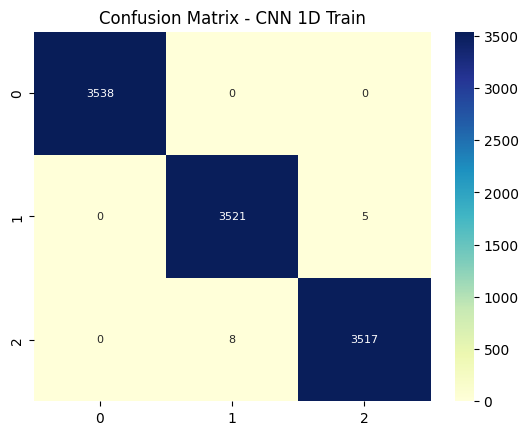

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


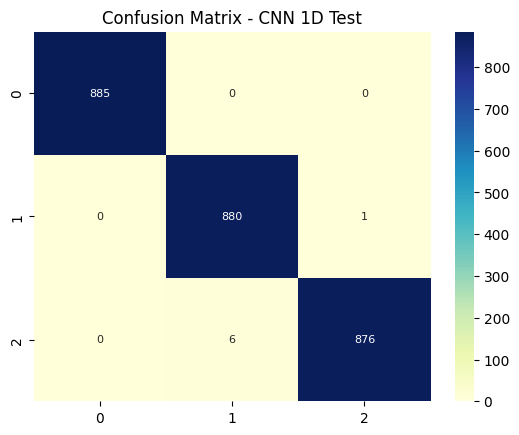

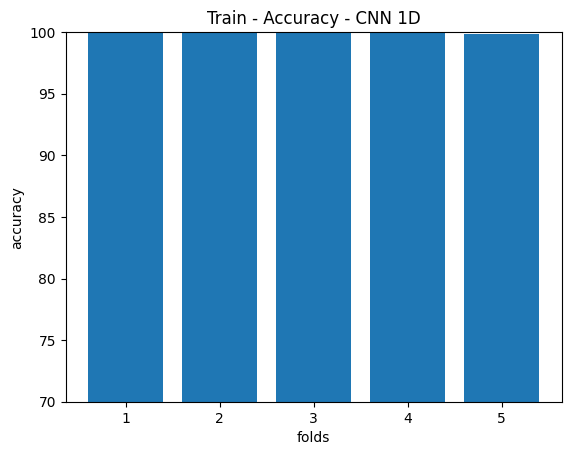

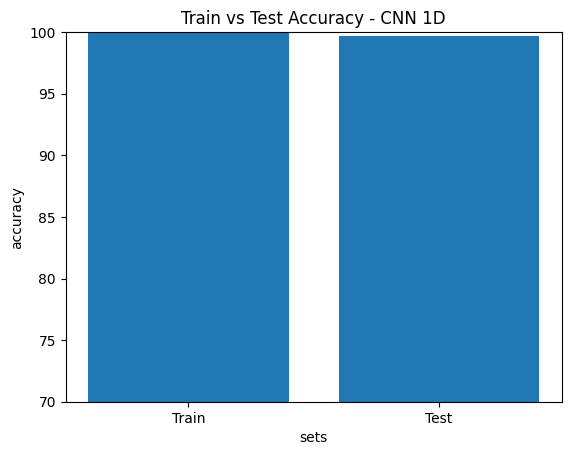

In [ ]:
# Split into training and test sets (80% train, 20% test)
X_train_split, X_test_split, y_train_positional_split, y_test_positional_split = train_test_split(
    X, y_positional, test_size=0.2, random_state=sd, stratify=y_labels)

X_1D_train = X_train_split.reshape([-1, samples_per_block, 1])
X_1D_test = X_test_split.reshape([-1, samples_per_block, 1])
input_shape = (samples_per_block, 1)   # Reshaped input

class CNN_1D():
    def __init__(self):
        self.model = self.CreateModel()
        self.model.summary()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(3, activation='softmax')
        ])

        # Optimizer with a slightly higher learning rate
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model


# Training with k-fold validation
kSplits = 5
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)
accuracy_1D = []
precision_1D = []
recall_1D = []
log_loss_1D = []
balanced_accuracy_1D = []  # Store balanced accuracy for each fold
accuracy_1D_test = []
precision_1D_test = []
recall_1D_test = []
log_loss_1D_test = []
balanced_accuracy_1D_test = []  # Store balanced accuracy for test set

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
start_time = time.time()

for train_idx, test_idx in kfold.split(X, y_positional):
    Classification_1D = CNN_1D()
    Classification_1D.model.fit(X[train_idx], y_positional[train_idx],
                                validation_data=(X[test_idx], y_positional[test_idx]),
                                epochs=100, callbacks=[early_stopping], verbose=1)
    
    # Train set metrics
    y_pred_proba_train = Classification_1D.model.predict(X[train_idx])
    y_pred_train = np.argmax(y_pred_proba_train, axis=1)
    y_true_train = np.argmax(y_positional[train_idx], axis=1)

    accuracy_1D.append(accuracy_score(y_true_train, y_pred_train))
    precision_1D.append(precision_score(y_true_train, y_pred_train, average='weighted'))
    recall_1D.append(recall_score(y_true_train, y_pred_train, average='weighted'))
    log_loss_1D.append(log_loss(y_true_train, y_pred_proba_train))
    balanced_accuracy_1D.append(balanced_accuracy_score(y_true_train, y_pred_train))  # Balanced accuracy for train set
    
    # Test set metrics
    y_pred_proba_test = Classification_1D.model.predict(X[test_idx])
    y_pred_test = np.argmax(y_pred_proba_test, axis=1)
    y_true_test = np.argmax(y_positional[test_idx], axis=1)

    accuracy_1D_test.append(accuracy_score(y_true_test, y_pred_test))
    precision_1D_test.append(precision_score(y_true_test, y_pred_test, average='weighted'))
    recall_1D_test.append(recall_score(y_true_test, y_pred_test, average='weighted'))
    log_loss_1D_test.append(log_loss(y_true_test, y_pred_proba_test))
    balanced_accuracy_1D_test.append(balanced_accuracy_score(y_true_test, y_pred_test))  # Balanced accuracy for test set

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Computation Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Aggregated metrics
CNN_1D_train_accuracy = np.mean(accuracy_1D) * 100
CNN_1D_test_accuracy = np.mean(accuracy_1D_test) * 100
CNN_1D_train_precision = np.mean(precision_1D) * 100
CNN_1D_test_precision = np.mean(precision_1D_test) * 100
CNN_1D_train_recall = np.mean(recall_1D) * 100
CNN_1D_test_recall = np.mean(recall_1D_test) * 100
CNN_1D_train_log_loss = np.mean(log_loss_1D)
CNN_1D_test_log_loss = np.mean(log_loss_1D_test)
CNN_1D_train_balanced_accuracy = np.mean(balanced_accuracy_1D) * 100  # Average balanced accuracy for train set
CNN_1D_test_balanced_accuracy = np.mean(balanced_accuracy_1D_test) * 100  # Average balanced accuracy for test set

# Print metrics
print(f"Train Accuracy: {CNN_1D_train_accuracy:.2f}%")
print(f"Test Accuracy: {CNN_1D_test_accuracy:.2f}%")
print(f"Train Precision: {CNN_1D_train_precision:.2f}%")
print(f"Test Precision: {CNN_1D_test_precision:.2f}%")
print(f"Train Recall: {CNN_1D_train_recall:.2f}%")
print(f"Test Recall: {CNN_1D_test_recall:.2f}%")
print(f"Train Log Loss: {CNN_1D_train_log_loss:.4f}")
print(f"Test Log Loss: {CNN_1D_test_log_loss:.4f}")
print(f"Train Balanced Accuracy: {CNN_1D_train_balanced_accuracy:.2f}%")
print(f"Test Balanced Accuracy: {CNN_1D_test_balanced_accuracy:.2f}%")

# Confusion Matrix Calculation
# def ConfusionMatrix(Model, X, y):
#     y_pred = np.argmax(Model.model.predict(X), axis=1)
#     ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
#     return ConfusionMat

def ConfusionMatrix(Model, X, y):
    y_pred_proba = Model.model.predict(X)  # Use Model.model instead of Model
    y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels
    y_true = np.argmax(y, axis=1)  # Convert one-hot labels to class indices
    return confusion_matrix(y_true, y_pred)

# Plot results - CNN 1D
plt.figure(1)
plt.title('Confusion Matrix - CNN 1D Train')
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_train, y_train_positional_split), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(2)
plt.title('Confusion Matrix - CNN 1D Test')
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_test, y_test_positional_split), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(3)
plt.title('Train - Accuracy - CNN 1D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_1D])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(4)
plt.title('Train vs Test Accuracy - CNN 1D')
plt.bar([1, 2], [CNN_1D_train_accuracy, CNN_1D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('sets')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

In [1]:
'''Train Accuracy: 99.92%
Test Accuracy: 99.71%
Train Precision: 99.92%
Test Precision: 99.71%
Train Recall: 99.92%
Test Recall: 99.71%
Train Log Loss: 0.0026
Test Log Loss: 0.0081
Train Balanced Accuracy: 99.92%
Test Balanced Accuracy: 99.71%'''

'Train Accuracy: 99.92%\nTest Accuracy: 99.71%\nTrain Precision: 99.92%\nTest Precision: 99.71%\nTrain Recall: 99.92%\nTest Recall: 99.71%\nTrain Log Loss: 0.0026\nTest Log Loss: 0.0081\nTrain Balanced Accuracy: 99.92%\nTest Balanced Accuracy: 99.71%'

### Time Series-Based Train-Test Split

In [4]:
def time_series_stratified_split(X, y, train_ratio = 0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        # print("X_train shape:", len(X_train))
        y_train.append(y[train_idx])
        # print("y_train shape:", len(X_train))
        X_test.append(X[test_idx])
        # print("X_train shape:", len(X_train))
        y_test.append(y[test_idx])
        # print("y_test shape:", len(X_train))

    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )


In [5]:
X_train, y_train, X_test, y_test = time_series_stratified_split(X, y_positional) # type: ignore

X_1D_train = X_train.reshape(-1, samples_per_block, 1) # type: ignore
X_1D_test = X_test.reshape(-1, samples_per_block, 1) # type: ignore

input_shape = (samples_per_block, 1)
y_train_classes = np.argmax(y_train, axis=1)

X_1D_train.shape, X_1D_test.shape, y_train_classes.shape

((9599, 1600, 1), (2400, 1600, 1), (9599,))

In [6]:
from sklearn.model_selection import StratifiedKFold

k_split = 5
kfold = StratifiedKFold(n_splits=k_split, shuffle=False)

In [7]:

# Training with k-fold validation
class CNN_1D():
    def __init__(self):
        self.model = self.CreateModel()
        self.model.summary()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(3, activation='softmax')
        ])

        # Optimizer with a slightly higher learning rate
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.summary()
        return model

foldername_cnn = os.path.join(os.getcwd(), "Paderborn_baseline", "1D_CNN")
os.makedirs(foldername_cnn, exist_ok=True)

from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, balanced_accuracy_score

# Metric storage
accuracy_1D_cnn, precision_1D_cnn, recall_1D_cnn, f1_1D_cnn, log_loss_1D_cnn, balanced_accuracy_1D_cnn = [], [], [], [], [], []
accuracy_1D_test_cnn, precision_1D_test_cnn, recall_1D_test_cnn, f1_1D_test_cnn, log_loss_1D_test_cnn, balanced_accuracy_1D_test_cnn = [], [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn, f"best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D()
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()


    print(f"Best model saved at: {checkpoint_filepath}")





Fold 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8466 - loss: 0.3907
Epoch 1: val_accuracy improved from -inf to 0.33281, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_1.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8468 - loss: 0.3901 - val_accuracy: 0.3328 - val_loss: 1.4108
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9487 - loss: 0.1198
Epoch 2: val_accuracy improved from 0.33281 to 0.40885, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_1.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9487 - loss: 0.1197 - val_accuracy: 0.4089 - val_loss: 1.3291
Epoch 3/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9637 - loss: 0.0878
Epoch 3: val_accuracy improved from 0.40885 to 0.76823, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_1.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8589 - loss: 0.3622
Epoch 1: val_accuracy improved from -inf to 0.33281, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_2.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8594 - loss: 0.3611 - val_accuracy: 0.3328 - val_loss: 3.8675
Epoch 2/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9531 - loss: 0.1134
Epoch 2: val_accuracy did not improve from 0.33281
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9531 - loss: 0.1134 - val_accuracy: 0.3328 - val_loss: 3.8282
Epoch 3/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9678 - loss: 0.0819
Epoch 3: val_accuracy improved from 0.33281 to 0.85365, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_2.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9678 - loss: 0.0819 - val_accuracy: 0.8536 - val_loss: 0.2874
Epoch 4/20
240/240 ━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7835 - loss: 0.4678
Epoch 1: val_accuracy improved from -inf to 0.33281, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_3.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7847 - loss: 0.4655 - val_accuracy: 0.3328 - val_loss: 2.4130
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9522 - loss: 0.1200
Epoch 2: val_accuracy improved from 0.33281 to 0.49896, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_3.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9522 - loss: 0.1200 - val_accuracy: 0.4990 - val_loss: 2.0530
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9668 - loss: 0.0888
Epoch 3: val_accuracy improved from 0.49896 to 0.80885, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_3.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7943 - loss: 0.4857
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_4.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7954 - loss: 0.4834 - val_accuracy: 0.3333 - val_loss: 4.0608
Epoch 2/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9418 - loss: 0.1493
Epoch 2: val_accuracy improved from 0.33333 to 0.36510, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_4.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9418 - loss: 0.1493 - val_accuracy: 0.3651 - val_loss: 2.8508
Epoch 3/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9599 - loss: 0.1055
Epoch 3: val_accuracy improved from 0.36510 to 0.99583, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_4.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7891 - loss: 0.4896
Epoch 1: val_accuracy improved from -inf to 0.33299, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_5.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7902 - loss: 0.4872 - val_accuracy: 0.3330 - val_loss: 4.8807
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9404 - loss: 0.1468
Epoch 2: val_accuracy did not improve from 0.33299
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9404 - loss: 0.1467 - val_accuracy: 0.3330 - val_loss: 4.7716
Epoch 3/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9681 - loss: 0.0953
Epoch 3: val_accuracy improved from 0.33299 to 0.90620, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_5.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9681 - loss: 0.0952 - val_accuracy: 0.9062 - val_loss: 0.2015
Epoch 4/20
238/240 ━━

In [9]:
print("1D CNN Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn}")
print(f"Precision: {precision_1D_test_cnn}")
print(f"Recall: {recall_1D_test_cnn}")
print(f"F1 Score: {f1_1D_test_cnn}")
print(f"Log Loss: {log_loss_1D_test_cnn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn}")

1D CNN Metrics:
Train Accuracy: [0.883, 0.999, 1.0, 0.958, 0.99]
Test Accuracy: [0.667, 0.668, 0.668, 0.666, 0.666]
Precision: [0.446, 0.785, 0.809, 0.82, 0.531]
Recall: [0.667, 0.668, 0.668, 0.666, 0.666]
F1 Score: [0.534, 0.538, 0.549, 0.551, 0.535]
Log Loss: [2.952, 4.181, 4.643, 2.942, 2.943]
Balanced Accuracy: [0.667, 0.668, 0.668, 0.666, 0.666]


### Full Code - Time Based Splitting

In [ ]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, balanced_accuracy_score, f1_score
import seaborn as sns
from scipy.io import loadmat
import time
import matplotlib.pyplot as plt

# Set Random Seed for Reproducibility
sd = 1
os.environ['PYTHONHASHSEED'] = str(sd)
np.random.seed(sd)
rn.seed(sd)
tf.random.set_seed(sd)

# Configuration
root_dir = './Paderborn_PreCase1_Data'

data_structure = {
    0: ("Healthy", ["K001", "K002", "K003", "K004", "K005"]),
    1: ("OR_Damage", ["KA04", "KA15", "KA16", "KA22", "KA30"]),
    2: ("IR_Damage", ["KI04", "KI14", "KI16", "KI18", "KI21"]),
}

# Data Extraction Function
def extract_signals_df(filepath, signal="all"):
    signals = {
        "vibration": 6,
        "current_1": 1,
        "current_2": 2,
    }
    mat = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    field = next(k for k in mat if not k.startswith("__"))
    struct = mat[field]
    X_channels = struct.X
    Y_channels = struct.Y
    if signal == "vibration":
        v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(v, columns=["vibration"])
    elif signal == "current":
        c1 = X_channels[signals["current_1"]].Data.flatten().reshape(-1, 1)
        c2 = Y_channels[signals["current_2"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(np.concatenate([c1, c2], axis=1), columns=["current_1", "current_2"])
    elif signal == "all":
        v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
        c1 = X_channels[signals["current_1"]].Data.flatten().reshape(-1, 1)
        c2 = Y_channels[signals["current_2"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(np.concatenate([v, c1, c2], axis=1),
                            columns=["vibration", "current_1", "current_2"])
    else:
        raise ValueError("Signal must be one of: 'vibration', 'current', or 'all'")

# Data Loading
def load_data():
    all_data = []
    for label, (category, folders) in data_structure.items():
        for folder in folders:
            folder_path = os.path.join(root_dir, folder)
            if not os.path.exists(folder_path):
                print(f"Warning: Folder {folder_path} not found.")
                continue
            mat_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".mat")])
            for filename in mat_files[1:2]:
                file_path = os.path.join(folder_path, filename)
                try:
                    df = extract_signals_df(file_path, signal="all")
                    df["label"] = label
                    df["sample"] = filename.replace(".mat", "")
                    all_data.append(df)
                    print(f"Loaded: {file_path}")
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Data Preprocessing
def preprocess_data(final_df):
    df_signals = final_df[["vibration", "label"]].copy()
    df_signals.rename(columns={"vibration": "signal"}, inplace=True)
    print("\nSignal DataFrame shape:", df_signals.shape)
    print(df_signals.head())
    
    grouped_signals = [
        df_signals[df_signals['label'] == i]['signal'].values.astype(float)
        for i in sorted(df_signals['label'].unique())
    ]
    return grouped_signals

# Data Sampling
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (
        round(adjusted_length / interval_length)
        - round(samples_per_block / interval_length)
        - 1
    )
    if No_of_blocks <= 0:
        return np.empty((0, samples_per_block))
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx : start_idx + samples_per_block].T
    return SplitData

# Data Preparation
def DataPreparation(DataList, interval_length, samples_per_block):
    for count, signal in enumerate(DataList):
        SplitData = Sampling(signal, interval_length, samples_per_block)
        if SplitData.shape[0] == 0:
            continue
        y = np.zeros([len(SplitData), len(DataList)])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        if count == 0:
            X = SplitData
            LabelPositional = y
            Label = y1
        else:
            X = np.append(X, SplitData, axis=0)
            LabelPositional = np.append(LabelPositional, y, axis=0)
            Label = np.append(Label, y1, axis=0)
    return X, LabelPositional, Label

# Data Splitting
def time_series_stratified_split(X, y, train_ratio=0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []
    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        y_train.append(y[train_idx])
        X_test.append(X[test_idx])
        y_test.append(y[test_idx])
    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )

# CNN Model Definition
class CNN_1D:
    def __init__(self, input_shape):
        self.model = self.CreateModel(input_shape)
        self.model.summary()
    
    def CreateModel(self, input_shape):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(3, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])
        return model

# Confusion Matrix Function
def ConfusionMatrix(Model, X, y):
    y_pred_proba = Model.model.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y, axis=1)
    return confusion_matrix(y_true, y_pred)

# Main Execution
def main():
    # Constants
    interval_length = 320
    samples_per_block = 1600
    k_split = 5
    
    # Load and preprocess data
    final_df = load_data()
    print("\nCombined data shape:", final_df.shape)
    print(final_df.head())
    
    grouped_signals = preprocess_data(final_df)
    X, y_positional, y_labels = DataPreparation(grouped_signals, interval_length, samples_per_block)
    
    # Split data
    X_train, y_train, X_test, y_test = time_series_stratified_split(X, y_positional)
    X_1D_train = X_train.reshape(-1, samples_per_block, 1)
    X_1D_test = X_test.reshape(-1, samples_per_block, 1)
    input_shape = (samples_per_block, 1)
    y_train_classes = np.argmax(y_train, axis=1)
    
    # Initialize metrics
    accuracy_1D_cnn, precision_1D_cnn, recall_1D_cnn = [], [], []
    f1_1D_cnn, log_loss_1D_cnn, balanced_accuracy_1D_cnn = [], [], []
    accuracy_1D_test_cnn, precision_1D_test_cnn, recall_1D_test_cnn = [], [], []
    f1_1D_test_cnn, log_loss_1D_test_cnn, balanced_accuracy_1D_test_cnn = [], [], []
    
    # K-Fold Cross Validation
    kfold = StratifiedKFold(n_splits=k_split, shuffle=False)
    foldername_cnn = os.path.join(os.getcwd(), "Paderborn_baseline", "1D_CNN")
    os.makedirs(foldername_cnn, exist_ok=True)
    
    start_time = time.time()
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
        print(f"\nFold {fold + 1}")
        checkpoint_filepath = os.path.join(foldername_cnn, f"best_model_{fold + 1}.keras")
        checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                    save_best_only=True, mode='max', verbose=1)
        
        # Train model
        model = CNN_1D(input_shape)
        model.model.fit(
            X_1D_train[train_idx], y_train[train_idx],
            validation_data=(X_1D_train[val_idx], y_train[val_idx]),
            epochs=20,
            verbose=1,
            callbacks=[checkpoint]
        )
        
        # Evaluate model
        best_model = load_model(checkpoint_filepath)
        y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
        y_pred_train = np.argmax(y_pred_train_probs, axis=1)
        y_true_train = np.argmax(y_train[train_idx], axis=1)
        
        # Training metrics
        accuracy_1D_cnn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
        precision_1D_cnn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
        recall_1D_cnn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
        f1_1D_cnn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
        log_loss_1D_cnn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
        balanced_accuracy_1D_cnn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))
        
        # Training confusion matrix (per fold)
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
        plt.title(f'1D CNN Train Confusion Matrix - Fold {fold + 1}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_train_fold_{fold + 1}.png"))
        plt.close()
        
        # Test evaluation
        y_pred_test_probs = best_model.predict(X_1D_test)
        y_pred_test = np.argmax(y_pred_test_probs, axis=1)
        y_true_test = np.argmax(y_test, axis=1)
        
        # Test metrics
        accuracy_1D_test_cnn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
        precision_1D_test_cnn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
        recall_1D_test_cnn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
        f1_1D_test_cnn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
        log_loss_1D_test_cnn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
        balanced_accuracy_1D_test_cnn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))
        
        # Test confusion matrix (per fold)
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
        plt.title(f'1D CNN Test Confusion Matrix - Fold {fold + 1}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_test_fold_{fold + 1}.png"))
        plt.close()
        
        print(f"Best model saved at: {checkpoint_filepath}")
    
    # Compute aggregated metrics
    CNN_1D_train_accuracy = np.mean(accuracy_1D_cnn) * 100
    CNN_1D_test_accuracy = np.mean(accuracy_1D_test_cnn) * 100
    CNN_1D_train_precision = np.mean(precision_1D_cnn) * 100
    CNN_1D_test_precision = np.mean(precision_1D_test_cnn) * 100
    CNN_1D_train_recall = np.mean(recall_1D_cnn) * 100
    CNN_1D_test_recall = np.mean(recall_1D_test_cnn) * 100
    CNN_1D_train_log_loss = np.mean(log_loss_1D_cnn)
    CNN_1D_test_log_loss = np.mean(log_loss_1D_test_cnn)
    CNN_1D_train_balanced_accuracy = np.mean(balanced_accuracy_1D_cnn) * 100
    CNN_1D_test_balanced_accuracy = np.mean(balanced_accuracy_1D_test_cnn) * 100
    
    # Print aggregated metrics
    print("1D CNN Metrics:")
    print(f"Train Accuracy: {CNN_1D_train_accuracy:.2f}%")
    print(f"Test Accuracy: {CNN_1D_test_accuracy:.2f}%")
    print(f"Train Precision: {CNN_1D_train_precision:.2f}%")
    print(f"Test Precision: {CNN_1D_test_precision:.2f}%")
    print(f"Train Recall: {CNN_1D_train_recall:.2f}%")
    print(f"Test Recall: {CNN_1D_test_recall:.2f}%")
    print(f"Train Log Loss: {CNN_1D_train_log_loss:.4f}")
    print(f"Test Log Loss: {CNN_1D_test_log_loss:.4f}")
    print(f"Train Balanced Accuracy: {CNN_1D_train_balanced_accuracy:.2f}%")
    print(f"Test Balanced Accuracy: {CNN_1D_test_balanced_accuracy:.2f}%")
    
    # Plot aggregated confusion matrices
    # Train confusion matrix (using the last best model)
    plt.figure(figsize=(6, 4))
    sns.heatmap(ConfusionMatrix(model, X_1D_train, y_train), annot=True, fmt='d', annot_kws={"fontsize": 8}, cmap="YlGnBu")
    plt.title('Confusion Matrix - CNN 1D Train')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, "1D_CNN_conf_matrix_train_aggregated.png"))
    plt.close()
    
    # Test confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(ConfusionMatrix(model, X_1D_test, y_test), annot=True, fmt='d', annot_kws={"fontsize": 8}, cmap="YlGnBu")
    plt.title('Confusion Matrix - CNN 1D Test')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, "1D_CNN_conf_matrix_test_aggregated.png"))
    plt.close()
    
    # Plot training accuracy per fold
    plt.figure(figsize=(6, 4))
    plt.bar(np.arange(1, k_split + 1), [i * 100 for i in accuracy_1D_cnn])
    plt.title('Train - Accuracy - CNN 1D')
    plt.ylabel('Accuracy')
    plt.xlabel('Folds')
    plt.ylim([70, 100])
    plt.savefig(os.path.join(foldername_cnn, "1D_CNN_train_accuracy_per_fold.png"))
    plt.close()
    
    # Plot train vs test accuracy
    plt.figure(figsize=(6, 4))
    plt.bar([1, 2], [CNN_1D_train_accuracy, CNN_1D_test_accuracy])
    plt.title('Train vs Test Accuracy - CNN 1D')
    plt.ylabel('Accuracy')
    plt.xlabel('Sets')
    plt.xticks([1, 2], ['Train', 'Test'])
    plt.ylim([70, 100])
    plt.savefig(os.path.join(foldername_cnn, "1D_CNN_train_vs_test_accuracy.png"))
    plt.close()
    
    # Print computation time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total Computation Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

if __name__ == "__main__":
    main()

Loaded: ./Paderborn_PreCase1_Data/K001/N09_M07_F10_K001_10.mat
Loaded: ./Paderborn_PreCase1_Data/K002/N09_M07_F10_K002_2.mat
Loaded: ./Paderborn_PreCase1_Data/K003/N09_M07_F10_K003_2.mat
Loaded: ./Paderborn_PreCase1_Data/K004/N09_M07_F10_K004_2.mat
Loaded: ./Paderborn_PreCase1_Data/K005/N09_M07_F10_K005_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA04/N09_M07_F10_KA04_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA15/N09_M07_F10_KA15_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA16/N09_M07_F10_KA16_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA22/N09_M07_F10_KA22_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA30/N09_M07_F10_KA30_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI04/N09_M07_F10_KI04_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI14/N09_M07_F10_KI14_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI16/N09_M07_F10_KI16_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI18/N09_M07_F10_KI18_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI21/N09_M07_F10_KI21_2.mat

Combined data shape: (3845043, 5)
   vibration  current_1  current_2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8463 - loss: 0.3913
Epoch 1: val_accuracy improved from -inf to 0.33281, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_1.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8468 - loss: 0.3901 - val_accuracy: 0.3328 - val_loss: 1.4108
Epoch 2/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9487 - loss: 0.1198
Epoch 2: val_accuracy improved from 0.33281 to 0.40885, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_1.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9487 - loss: 0.1197 - val_accuracy: 0.4089 - val_loss: 1.3291
Epoch 3/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9637 - loss: 0.0878
Epoch 3: val_accuracy improved from 0.40885 to 0.76823, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_1.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8592 - loss: 0.3616
Epoch 1: val_accuracy improved from -inf to 0.33281, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_2.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8594 - loss: 0.3611 - val_accuracy: 0.3328 - val_loss: 3.8675
Epoch 2/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9531 - loss: 0.1134
Epoch 2: val_accuracy did not improve from 0.33281
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9531 - loss: 0.1134 - val_accuracy: 0.3328 - val_loss: 3.8282
Epoch 3/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9678 - loss: 0.0819
Epoch 3: val_accuracy improved from 0.33281 to 0.85365, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_2.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9678 - loss: 0.0819 - val_accuracy: 0.8536 - val_loss: 0.2874
Epoch 4/20
240/240 ━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7839 - loss: 0.4670
Epoch 1: val_accuracy improved from -inf to 0.33281, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_3.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7847 - loss: 0.4655 - val_accuracy: 0.3328 - val_loss: 2.4130
Epoch 2/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9522 - loss: 0.1200
Epoch 2: val_accuracy improved from 0.33281 to 0.49896, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_3.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9522 - loss: 0.1200 - val_accuracy: 0.4990 - val_loss: 2.0530
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9668 - loss: 0.0888
Epoch 3: val_accuracy improved from 0.49896 to 0.80885, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_3.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7947 - loss: 0.4849
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_4.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7954 - loss: 0.4834 - val_accuracy: 0.3333 - val_loss: 4.0608
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9418 - loss: 0.1493
Epoch 2: val_accuracy improved from 0.33333 to 0.36510, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_4.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9418 - loss: 0.1493 - val_accuracy: 0.3651 - val_loss: 2.8508
Epoch 3/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9599 - loss: 0.1055
Epoch 3: val_accuracy improved from 0.36510 to 0.99583, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_4.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7895 - loss: 0.4888
Epoch 1: val_accuracy improved from -inf to 0.33299, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_5.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7902 - loss: 0.4872 - val_accuracy: 0.3330 - val_loss: 4.8807
Epoch 2/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9403 - loss: 0.1468
Epoch 2: val_accuracy did not improve from 0.33299
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9404 - loss: 0.1467 - val_accuracy: 0.3330 - val_loss: 4.7716
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9681 - loss: 0.0953
Epoch 3: val_accuracy improved from 0.33299 to 0.90620, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_baseline/1D_CNN/best_model_5.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9681 - loss: 0.0952 - val_accuracy: 0.9062 - val_loss: 0.2015
Epoch 4/20
239/240 ━

AttributeError: 'Sequential' object has no attribute 'model'

<Figure size 600x400 with 0 Axes>

300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


<Axes: >

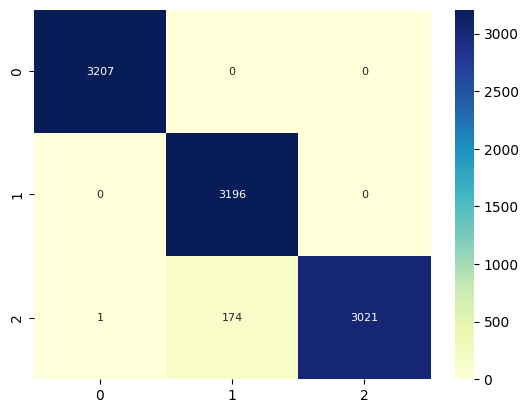

In [17]:
sns.heatmap(ConfusionMatrix(model, X_1D_train, y_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Text(50.722222222222214, 0.5, 'True')

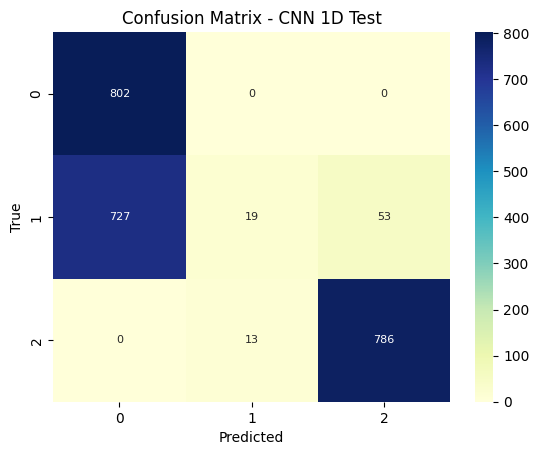

In [18]:
sns.heatmap(ConfusionMatrix(model, X_1D_test, y_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.title('Confusion Matrix - CNN 1D Test')
plt.xlabel('Predicted')
plt.ylabel('True')